In [1]:
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense
from keras.layers import Dropout, Input, BatchNormalization
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from sklearn.metrics import confusion_matrix
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import TimeDistributed
import matplotlib.pyplot as plt
import glob
import shutil
from pathlib import Path

In [ ]:
path = r"E:\Graduation Project/new"
awake_path_dst = r"/content/drive/MyDrive/Dataset/new/train/awake"
drowsy_path_dst = "/content/drive/MyDrive/Dataset/new/train/drowsy"
count = 0

for path in Path(path).rglob('*.avi'):
    if(path.name == "nonsleepyCombination.avi"):
        print('here')
        new_vid_name = path.name + '_' + str(count) +'.avi'
        shutil.copyfile(path, os.path.join(awake_path_dst, new_vid_name))
    else: 
        new_vid_name = path.name + '_' + str(count) +'.avi'
        shutil.copyfile(path, os.path.join(drowsy_path_dst, new_vid_name))
    count += 1

here


FileNotFoundError: [Errno 2] No such file or directory: 'E:\\Graduation Project/new/awake\\nonsleepyCombination.avi_0.avi'

In [3]:
data_dir =r"E:\Graduation Project\Project Data\new\train"
img_height , img_width = 60,60
seq_len = 15
 
classes = ['awake', 'drowsy']
 

In [4]:
def frames_extraction(video_path):
    frames_list = []
    frames = []
     
    vidObj = cv2.VideoCapture(video_path)
    # Used as counter variable 
    count = 0
    success = True
    while success: 
         
        success, image = vidObj.read() 
        if success:
            image = cv2.resize(image, (img_height, img_width))
            norm_img = np.zeros((800,800))
            final_img = cv2.normalize(image,  norm_img, 0, 255, cv2.NORM_MINMAX)
            frames_list.append(final_img)
            count += 1
        else:
            print("Defected frame")
            count+=1
            break
        if(count == seq_len):
            if(len(frames_list) != 15):
                frames_list = []
                count = 1
                continue
            frames.append(frames_list)
            frames_list = []
            count = 1
   
    return frames


In [5]:
def create_data(input_dir):
    X = []
    Y = []
     
    classes_list = os.listdir(input_dir)
     
    for c in classes_list:
        print(c)
        files_list = os.listdir(os.path.join(input_dir, c))
        for f in files_list:
            frames = frames_extraction(os.path.join(os.path.join(input_dir, c), f))
            # print(len(frames))
            for f in frames:       
                if len(f) == seq_len:
                    X.append(f)
                
                    y = [0]*len(classes)
                    y[classes.index(c)] = 1
                    Y.append(y)
     
    X = np.asarray(X)
    Y = np.asarray(Y)
    return X, Y

X, Y = create_data(data_dir)
# l = frames_extraction('new/train/awake/nonsleepyCombination.avi_176.avi')
# for ll in l:
    # print(len(ll))
print(X.shape, Y.shape)

awake
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defe

In [6]:
input_layer = Input((15 ,60 , 60 , 3))
  
x_train ,x_test , y_train , y_test = train_test_split(X , Y , test_size=.25 ,shuffle = True, random_state = 0 )
#x_test1, x_valid, y_test1, y_valid = train_test_split(x_test, y_test, test_size=0.30)

In [7]:
def creating_model(input_layer):
## convolutional layers
    conv_layer1 = Conv3D(filters=64, kernel_size=(3, 3, 3) , padding = 'same')(input_layer)
    pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2), padding = 'same')(conv_layer1)
    pooling_layer1 = BatchNormalization()(pooling_layer1)

    conv_layer2 = Conv3D(filters=64, kernel_size=(3, 3, 3) , padding = 'same')(pooling_layer1)
    pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)
    pooling_layer2 = BatchNormalization()(pooling_layer2)
## add max pooling to obtain the most imformatic features
    
    conv_layer3 = Conv3D(filters=128, kernel_size=(3, 3, 3),padding='same' )(pooling_layer2)
    conv_layer4 = Conv3D(filters=128, kernel_size=(3, 3, 3),padding='same')(conv_layer3)
    pooling_layer3 = MaxPool3D(pool_size =(2,2,2),padding='same')(conv_layer4)
    pooling_layer3 = BatchNormalization()(pooling_layer3)

    conv_layer5 = Conv3D(filters=256, kernel_size=(6, 1, 1) ,padding='same')(pooling_layer3)
    conv_layer6 = Conv3D(filters=512, kernel_size=(1,1,1), padding='same')(conv_layer5)
    pooling_layer4 = MaxPool3D(pool_size=(2,2,2), padding='same' )(conv_layer6)
    pooling_layer4 = BatchNormalization()(pooling_layer4)
## perform batch normalization on the convolution outputs before feeding it to MLP architecture
    
    flatten_layer = Flatten()(pooling_layer4)
    dense_layer1 = Dense(units = 128 , activation = 'relu')(flatten_layer)
    
    
    #dense_layer1 = Dropout(0.2)(dense_layer1)
    #dense_layer2 = Dense(units=32, activation='relu')(dense_layer1)
    #dense_layer2 = Dropout(0.2)(dense_layer2)
    #dense_layer3 = Dense(units  = 16 , activation=('relu'))(dense_layer2)
    #dense_layer3 = Dropout(.2)(dense_layer3)
    #dense_layer4 = Dense(units = 8 , activation = 'relu')(dense_layer3)
    #dense_layer4 = Dropout(.2)(dense_layer4)
    #dense_layer5 = Dense(units = 4 , activation = 'relu')(dense_layer4)
    #dense_layer5 = Dropout(.2)(dense_layer5)
    output_layer = Dense(units=2, activation='sigmoid')(dense_layer1)

## define the model with input layer and output layer
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [8]:
!pip install git+https://github.com/JihongJu/keras-resnet3d.git
from resnet3d import Resnet3DBuilder
#from lib.model_ResNet3D import Resnet3DBuilder
model = Resnet3DBuilder.build_resnet_50((15, 60, 60, 3), 2)

#model = creating_model(input_layer)
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

history = model.fit(x=x_train , y= y_train, batch_size=15, epochs=18 , validation_split = .25)


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
#loss, accuracy = model.evaluate((x_test,y_test))
print(sum(acc)/18)
print(sum(val_acc)/18)
print(sum(loss)/18)
print(sum(val_loss)/18)

  Running command git clone -q https://github.com/JihongJu/keras-resnet3d.git 'C:\Users\mosta\AppData\Local\Temp\pip-req-build-xgvyds59'
  Running command git submodule update --init --recursive -q


  Cloning https://github.com/JihongJu/keras-resnet3d.git to c:\users\mosta\appdata\local\temp\pip-req-build-xgvyds59
  Resolved https://github.com/JihongJu/keras-resnet3d.git to commit 6e3a5c8b50f34d5e62193efa3fad88517c012707
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 15, 60, 60,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 8, 30, 30, 6  65920       ['input_2[0][0]']                
                                4)                                                                
                                                                  

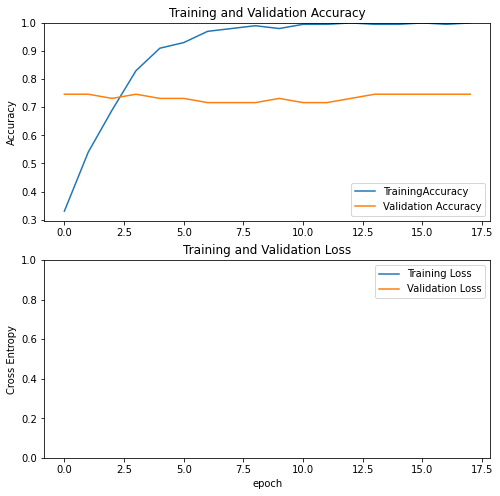

In [9]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='TrainingAccuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig(r'val2.png' , dpi = 300)
plt.show()


In [10]:
pred = model.predict(x_test)
pred = np.argmax(pred, axis=1)
y_test = np.argmax(y_test , axis =1)
confusion = confusion_matrix(y_test , pred , labels=[0 , 1])
print(confusion)

[[ 1 22]
 [ 4 62]]


In [11]:
from sklearn.metrics import classification_report
#y_test = np.argmax(y_test , axis =1)
#Y_TEST = np.argmax(y_valid, axis=1)
#y_pred = model.predict(x_test)

print(classification_report(y_test, pred))
#print(confusion_matrix(y_test , y_pred , labels=[0 , 1]))

              precision    recall  f1-score   support

           0       0.20      0.04      0.07        23
           1       0.74      0.94      0.83        66

    accuracy                           0.71        89
   macro avg       0.47      0.49      0.45        89
weighted avg       0.60      0.71      0.63        89



In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Mean Absolute Error')
plt.plot(val_acc, label='Validation Mean Absolute Error')
plt.legend(loc='lower right')
plt.ylabel('Mean Absolute Error')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Mean Absolute Error')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig(r'val2.png' , dpi = 300)
plt.show()
